# Group 14 - Project FP01
## Time series anomaly detection - Autoencoder

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [5]:
# plot_signals(df, df_action, "Normal signals", saveplot=False)
# plot_signals(df_collision, df_action_collision, "Collision signals", saveplot=False)
# plot_signals(df_collision_1, df_action_collision_1, "Collision signals 1", saveplot=False)
# plot_signals(df_collision_5, df_action_collision_5, "Collision signals 5", saveplot=False)

### Features Exctraction

In [6]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 150.39251828193665 seconds ---


In [7]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (164, 2200)
y_test shape: (164,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (164, 96)
y_test shape: (164,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (141, 2200)
y_test shape: (141,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (141, 96)
y_test shape: (141,)


In [8]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [9]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

## AutoEncoder

In [10]:
from algorithms.autoencoder import AutoEncoder

classifier = AutoEncoder(
    name='AutoEncoder',
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    hidden_size=32,
    sequence_length=5,
    train_gaussian_percentage=0.25,
    seed=42,
    gpu=None,
    details=True
)

# Train the AutoEncoder on normal data
classifier.fit(X_train)

print("AutoEncoder training completed.")

100%|██████████| 100/100 [00:10<00:00,  9.16it/s]

AutoEncoder training completed.


### Anomaly Detection

In [12]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [29]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 11 with threshold 2502.92066358664, std
Number of anomalies detected: 105 with threshold 381.401240899639, mad
Number of anomalies detected: 16 with threshold 2041.1501885585585, percentile
Number of anomalies detected: 16 with threshold 2050.751298949901, IQR

Number of anomalies detected: 6 with threshold 2385.348516051506, std
Number of anomalies detected: 52 with threshold 158.5949724772964, mad
Number of anomalies detected: 9 with threshold 1878.520614041195, percentile
Number of anomalies detected: 17 with threshold 498.65784751872883, IQR

Number of anomalies detected: 5 with threshold 2395.2284440121225, std
Number of anomalies detected: 16 with threshold 1692.8350265923068, mad
Number of anomalies detected: 8 with threshold 2102.417434633238, percentile
Number of anomalies detected: 4 with threshold 2654.5823369965565, IQR



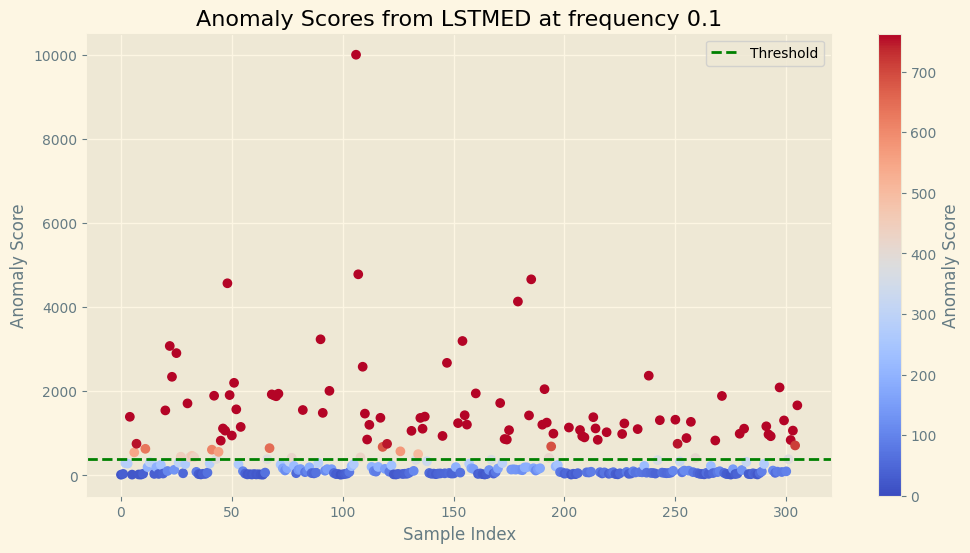

Number of anomalies detected: 105


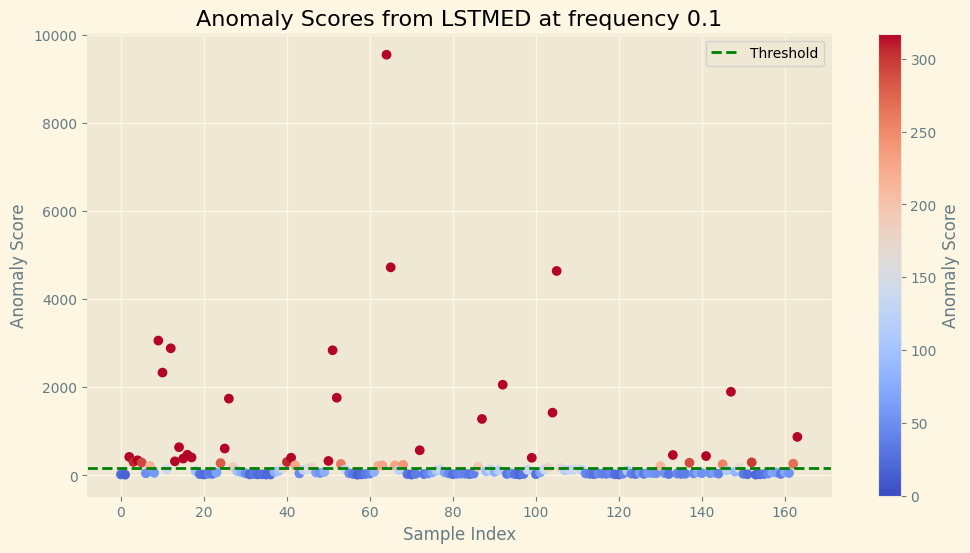

Number of anomalies detected: 52


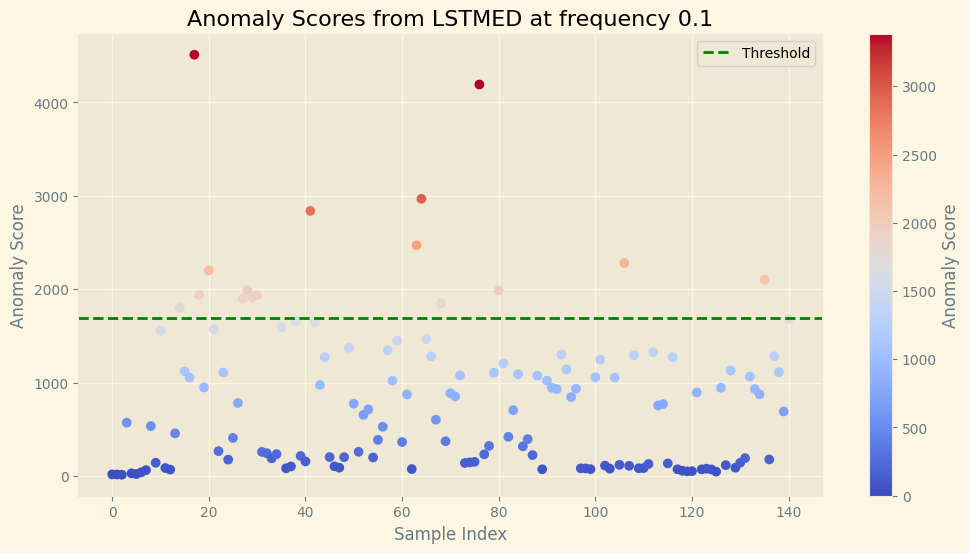

Number of anomalies detected: 16


In [30]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [31]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [32]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

ROC AUC Score: 0.9756
Detected anomaly class: 1
Threshold: 381.4012
F1 Score: 0.8571
Accuracy: 0.9020
Precision: 0.8571
Recall: 0.8571
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       201
           1       0.86      0.86      0.86       105

    accuracy                           0.90       306
   macro avg       0.89      0.89      0.89       306
weighted avg       0.90      0.90      0.90       306

############################################
ROC AUC Score: 0.9759
Detected anomaly class: 1
Threshold: 158.5950
F1 Score: 0.7816
Accuracy: 0.8841
Precision: 0.6538
Recall: 0.9714
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       129
           1       0.65      0.97      0.78        35

    accuracy                           0.88       164
   macro avg       0.82      0.92      0.85       164
weighted avg       0.92      0.88      0.89       164

###############################

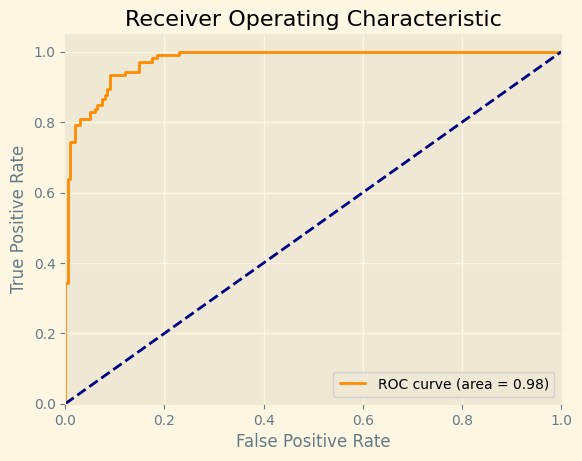

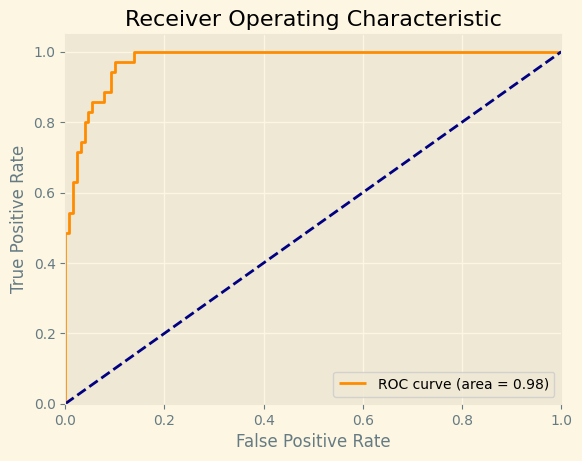

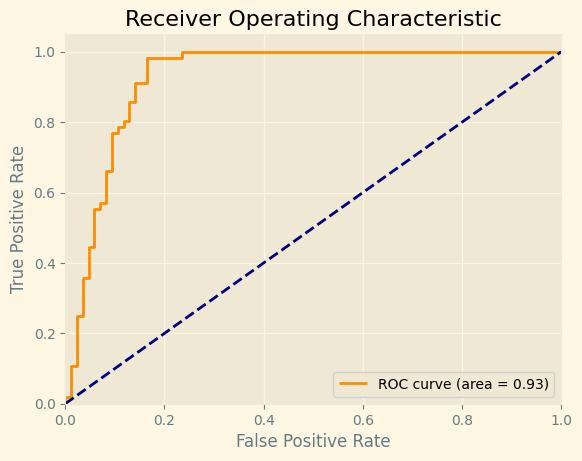

In [33]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

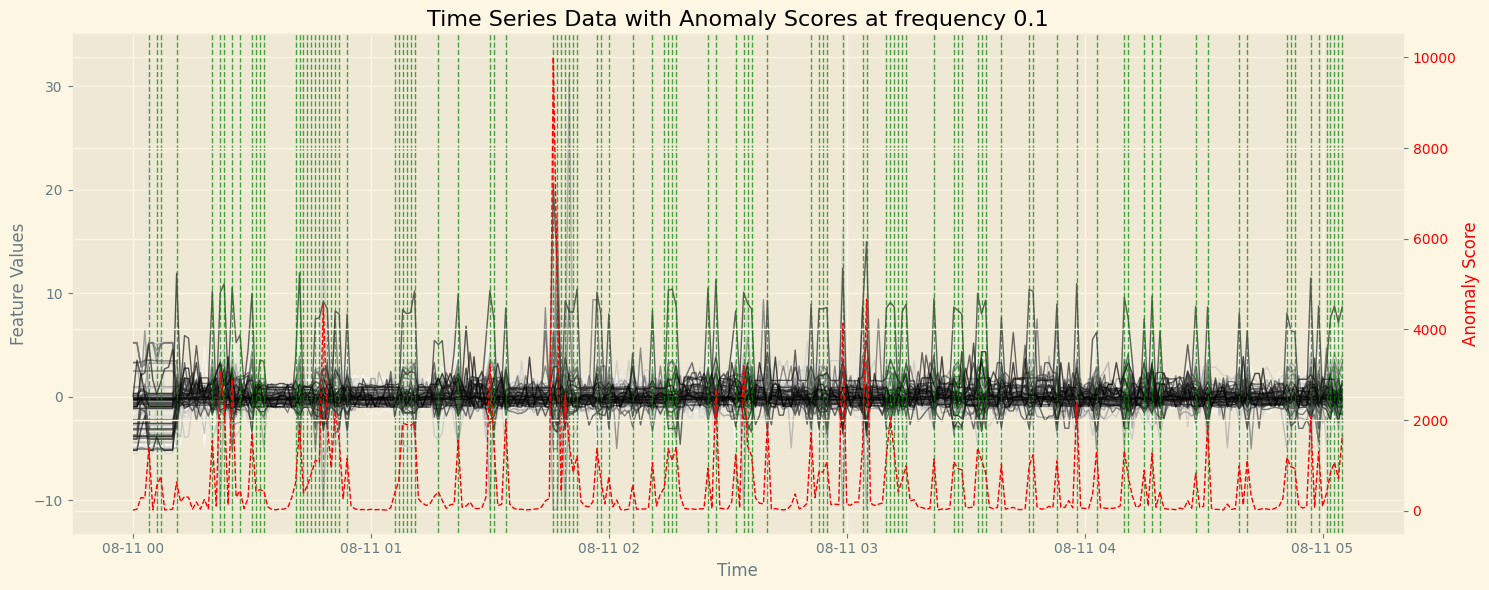

Top 105 Anomalies:
              timestamp  anomaly_score  \
106 2022-08-11 01:46:00   10008.579941   
107 2022-08-11 01:47:00    4784.252919   
185 2022-08-11 03:05:00    4664.763618   
48  2022-08-11 00:48:00    4570.829200   
179 2022-08-11 02:59:00    4136.495262   
..                  ...            ...   
193 2022-08-11 03:13:00     416.607426   
259 2022-08-11 04:19:00     412.655331   
43  2022-08-11 00:43:00     390.699303   
66  2022-08-11 01:06:00     386.925109   
301 2022-08-11 05:01:00     384.824987   

     machine_nameKuka Robot_apparent_power-_Average power  \
106                                          -1.885449      
107                                          -1.181816      
185                                          -1.065886      
48                                           -0.707436      
179                                          -1.338344      
..                                                 ...      
193                                           0.0

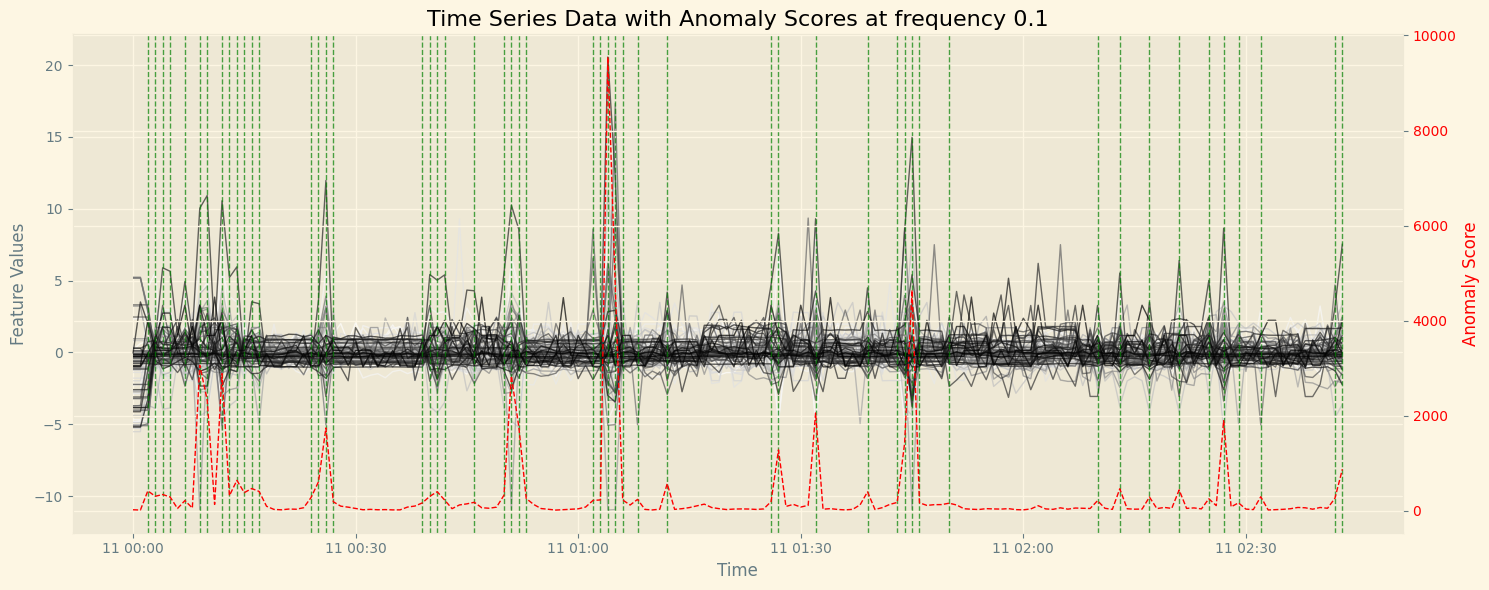

Top 52 Anomalies:
              timestamp  anomaly_score  \
64  2022-08-11 01:04:00    9546.624185   
65  2022-08-11 01:05:00    4722.314065   
105 2022-08-11 01:45:00    4640.468422   
9   2022-08-11 00:09:00    3060.725572   
12  2022-08-11 00:12:00    2885.578826   
51  2022-08-11 00:51:00    2840.736416   
10  2022-08-11 00:10:00    2334.481589   
92  2022-08-11 01:32:00    2058.858008   
147 2022-08-11 02:27:00    1898.787081   
52  2022-08-11 00:52:00    1763.677302   
26  2022-08-11 00:26:00    1743.483192   
104 2022-08-11 01:44:00    1425.665167   
87  2022-08-11 01:27:00    1282.109027   
163 2022-08-11 02:43:00     874.869326   
14  2022-08-11 00:14:00     641.662022   
25  2022-08-11 00:25:00     611.803540   
72  2022-08-11 01:12:00     572.300988   
16  2022-08-11 00:16:00     469.872553   
133 2022-08-11 02:13:00     464.409352   
141 2022-08-11 02:21:00     440.221879   
2   2022-08-11 00:02:00     420.977763   
17  2022-08-11 00:17:00     408.691695   
41  2022-08-11 0

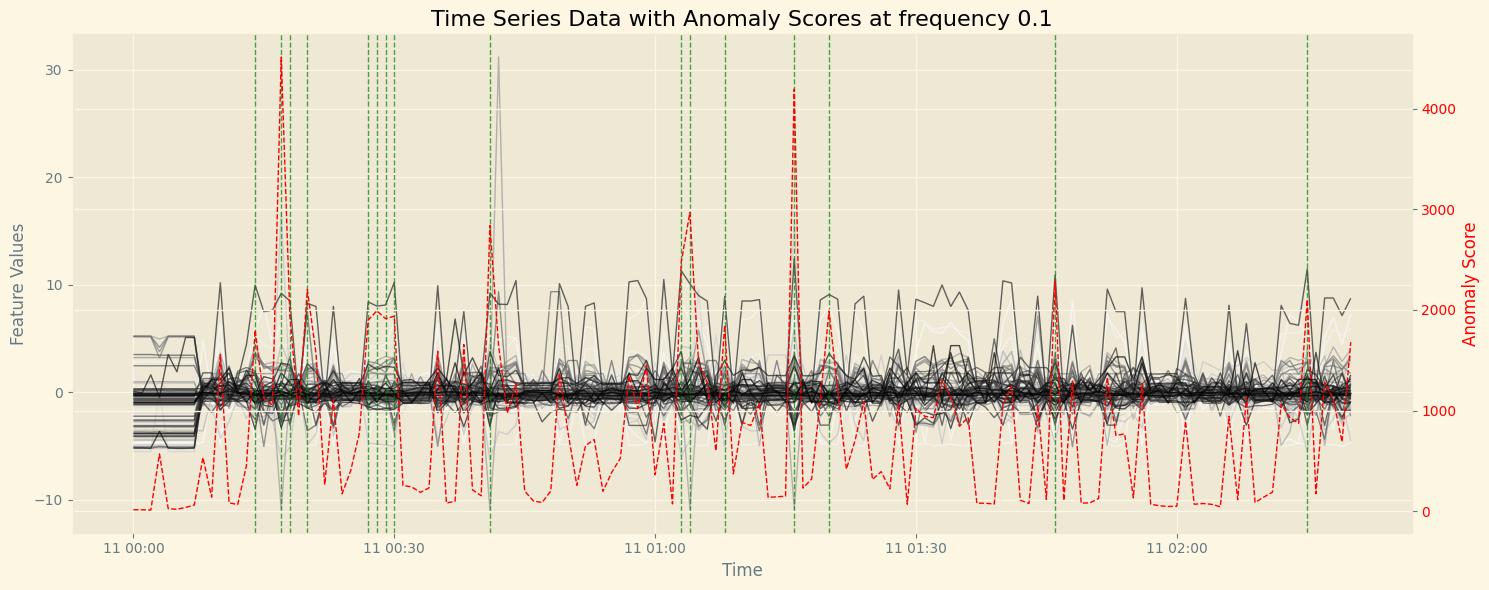

Top 16 Anomalies:
              timestamp  anomaly_score  \
17  2022-08-11 00:17:00    4511.705879   
76  2022-08-11 01:16:00    4192.879412   
64  2022-08-11 01:04:00    2968.333372   
41  2022-08-11 00:41:00    2839.103751   
63  2022-08-11 01:03:00    2471.506235   
106 2022-08-11 01:46:00    2281.357268   
20  2022-08-11 00:20:00    2201.931237   
135 2022-08-11 02:15:00    2102.417435   
28  2022-08-11 00:28:00    1991.457090   
80  2022-08-11 01:20:00    1988.224772   
18  2022-08-11 00:18:00    1938.263602   
30  2022-08-11 00:30:00    1938.138344   
29  2022-08-11 00:29:00    1914.097459   
27  2022-08-11 00:27:00    1900.223965   
68  2022-08-11 01:08:00    1847.211015   
14  2022-08-11 00:14:00    1800.043938   

     machine_nameKuka Robot_apparent_power-_Average power  \
17                                           -0.707436      
76                                           -1.338344      
64                                           -0.859449      
41                     

In [34]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)